# Equity Risk Premium Analysis
<p style="color:darkblue; "><b>A TurningBull Notebook</b>

This month's notebook will focus on hypothesis testing.  We'll demonstrate its application by analyzing the Equity Risk Premium (ERP) of U.S. equities over the risk-free rate since 1993.

We'll also use R, rather than Python, to carry out the analysis.  Most of the tools we'll need are included in R's base libraries.  However, we'll use a few additional libraries to acquire data.

Before jumping into the analysis, let's go over the 6-step process for conducting a hypothesis test:

**1. State the Hypothesis:** The primary objective of this analysis will be to test if there is a statistically significant benefit to investing in equities rather than socking your money away in "risk free" Treasuries.  We need to formulate two statements to support this assertion: a null hypothsis ($H_o$), and an alternate hypothesis ($H_a$).  $H_o$ is basically the statement for which we hope our data provides evidence to reject, while $H_a$ is the opposite:

$$
H_o := ERP \le 0 \\
H_a := ERP \gt 0
$$

**2. Identify the appropriate test statistic:** Based on **(1)**, we conducting a a test of a single mean value, i.e., $\mu_{ERP} = 0$.  This calls for a *t-distributed* test statistic with *n-1* degrees of freedom.  The statistics is computed as:

$$
t = \frac{\bar{X} - \mu}{\frac{\sigma_{\bar{X}}}{\sqrt{n}}}
$$

**3. Specify the level of significance:** A typical significance level, $\alpha$, is 0.05, which corresponds to a 95% confidence level.  

**4. State the decision rule:** This step hinges on our selection of a critical value to compare against our test statistic.  The critical value will be the one that corresponds to the probability level and distribution of the statistic.

**5. Collect data and compute the statistic:** Most of the work in this analysis pertains to getting our data in the right form to compute the statistic.

**6. Make a decision:** Simply put, if the test statistic is greater than our critical value, then we can say there is sufficient evidence to reject $H_o$.  Otherwise, we will fail to reject the null hypothesis.  

Now, let's jump in it...

In [1]:
library(httr)           # For API requests (using FMP API)
library(jsonlite)       # For JSON parsing
library(data.table)     # For data manipulation
library(quantmod)       # For financial data, specifically Treasury yields

api_key <- read.csv("../.fmp_api.key", header = FALSE,
                    stringsAsFactors = FALSE)[1, 1]         # FMP API key

Loading required package: xts

Loading required package: zoo


Attaching package: ‘zoo’


The following objects are masked from ‘package:data.table’:

    yearmon, yearqtr


The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric



Attaching package: ‘xts’


The following objects are masked from ‘package:data.table’:

    first, last


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



We'll use the S&P 500 ETF **SPY** as a proxy for equity returns.  Since SPY pays periodic dividends, we'll also want to be sure to adjust the price history to reflect those payments.

We have already completed steps 1 - 3 above.

#### State the Decision Rule

Our choice of critical value depends on the number of data points feeding the analysis.  So, we'll first acquire the necessary data.

In [2]:
url <- paste("https://financialmodelingprep.com/stable/",
             "historical-price-eod/dividend-adjusted?",
             "symbol=SPY&from=1989-12-31&to=2025-02-28&",
             "apikey=", api_key, sep = "")                # FMP API URL
response <- GET(url)

# Get adjusted close data for SPY
if (status_code(response) == 200) {
  spy <- content(response, "text")
  spy <- fromJSON(spy)
  spy <- data.table(spy)
  spy <- spy[, c("date", "adjClose")]
  spy <- spy[order(date)]
} else {
  print("Error")
}

spy[, date := as.Date(date)]                        # Convert date to Date type
spy_monthly <- spy[, .(adjClose = last(adjClose)),
                   by = .(year(date), month(date))] # Resample to monthly data

# Reformat the date column and calculate returns
spy_monthly[, date := as.Date(paste(year, month, "01", sep = "-"))]
spy_monthly <- spy_monthly[, .(date, adjClose)]
spy_monthly[, rtn := round((adjClose / shift(adjClose) - 1) * 100, 2)]

There is no set definition for the risk-free rate, but U.S. Tresury yields are a common choice.  In this analysis we'll use the 3-Month T-Bill yields and 10-Year T-Bonds.

In [3]:
# Get 3-month and 10-year Treasury yields from Quantmod
getSymbols(c("DGS3MO", "DGS10"), src = "FRED")

# Resample to monthly data
t_bill <- data.table(date = index(DGS3MO), rate = DGS3MO[, 1])
t_bill <- t_bill[, .(rate = last(rate.DGS3MO)), by = .(year(date), month(date))]
t_bill[, date := as.Date(paste(year, month, "01", sep = "-"))]
t_bill <- t_bill[, .(date, rate)]
t_bill <- t_bill[, rate := round(rate / 12, 2)]  # Convert to monthly rate

t_bond <- data.table(date = index(DGS10), rate = DGS10[, 1])
t_bond <- t_bond[, .(rate = last(rate.DGS10)), by = year(date)]
t_bond[, date := as.Date(paste(year, "12", "31", sep = "-"))]
t_bond <- t_bond[, .(date, rate)]

[1] "DGS3MO" "DGS10"

To compute ERP, we simply subract the risk-free rate from the equity return.  We'll do this for both monthly and annual datasets.  

In [4]:
## Monthly ERP
erp_month <- na.omit(merge(spy_monthly, t_bill, by = "date", all.x = TRUE))
erp_month[, erp := rtn - rate]

## Annual ERP

# Function to compute annualized returns.
annual_return <- function(x) round((prod(1 + x / 100) - 1) * 100, 2)

erp_year <- na.omit(merge(spy_monthly[, .(annual_rtn = annual_return(rtn)),
                                      by = year(date)],
                          t_bond[, .(rate = last(rate)), by = year(date)],
                          all.x = TRUE))[-.N]
erp_year[, erp := annual_rtn - rate]


Before going further, let's talk about some important assumptions about our test construct:
1. Our random variable, in this case ERP, should be independent and identically distributed, or i.i.d.  Based on our sampling approach, i.e., using monthly returns and monthly Treasury yields, we satisfy this assumption.
2. Our data should be approximately normally distributed.  We can evaluate the Q-Q plot and histogram to check this assumption.
3. Our data should be continuous, which it is.

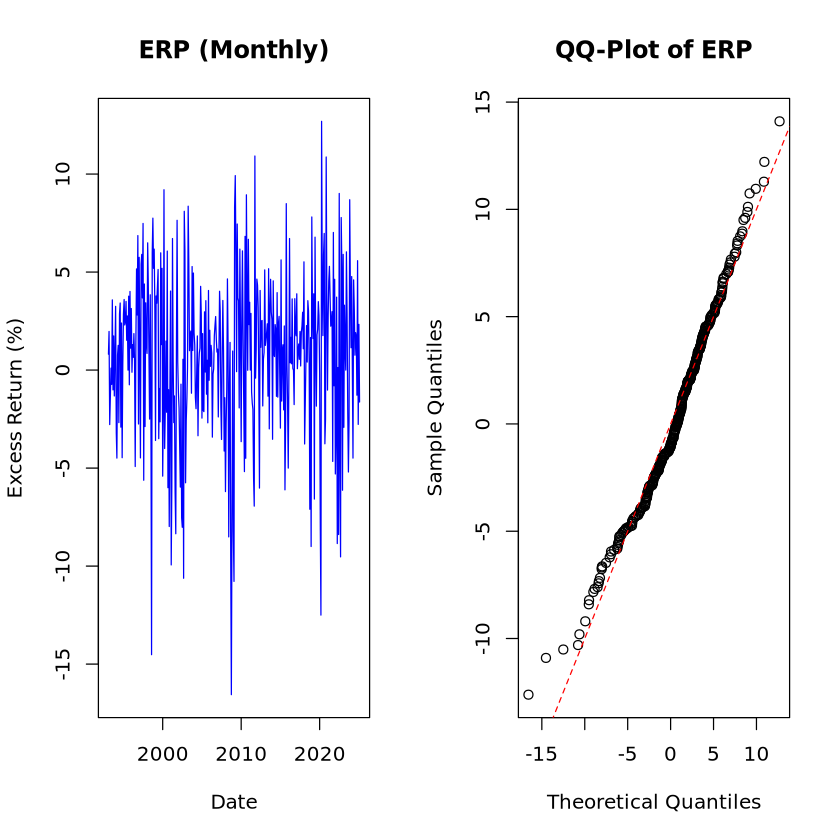

In [5]:
par(bg = "white", mfrow = c(1, 2))
plot(erp_month$date, erp_month$erp, type = "l", col = "blue",
     xlab = "Date", ylab = "Excess Return (%)",
     main = "ERP (Monthly)")
qqplot(erp_month$erp, y = rnorm(1000, mean(erp_month$erp),
                                sd = sd(erp_month$erp)),
       main = "QQ-Plot of ERP",
       xlab = "Theoretical Quantiles", ylab = "Sample Quantiles")
abline(0, 1, col = "red", lty = 2)

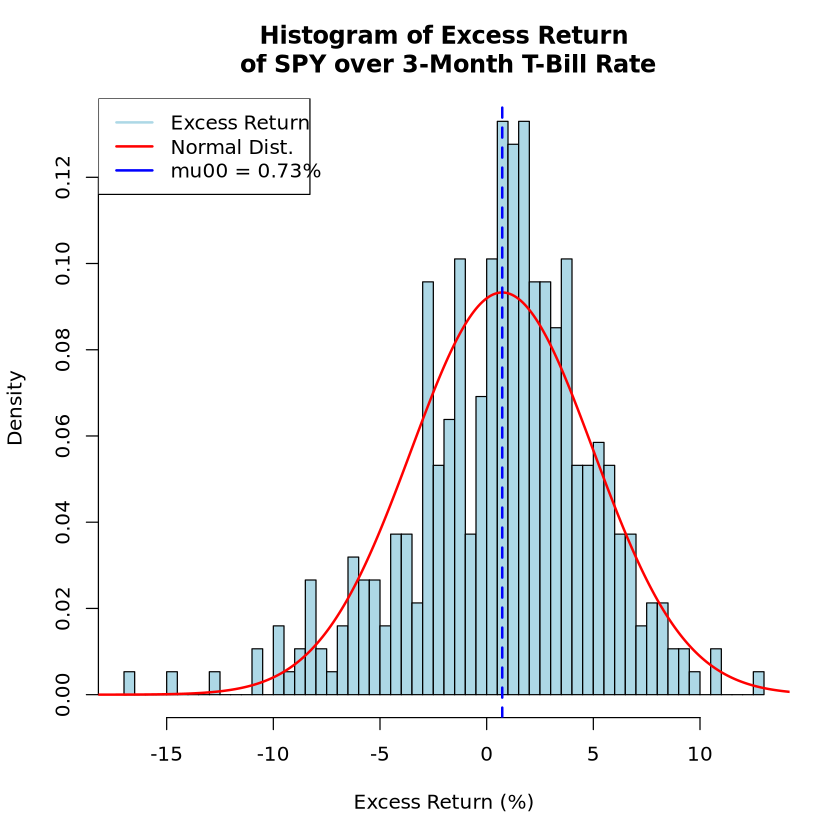

In [7]:
par(bg = "white")
hist(erp_month$erp, breaks = 50, col = "lightblue",
     xlab = "Excess Return (%)",
     main = "Histogram of Excess Return\n of SPY over 3-Month T-Bill Rate",
     probability = TRUE)
lines(seq(-20, 20, 0.1), dnorm(seq(-20, 20, 0.1),
                               mean = mean(erp_month$erp),
                               sd = sd(erp_month$erp)),
      col = "red", lwd = 2)
abline(v = mean(erp_month$erp), col = "blue", lwd = 2, lty = 2)
legend("topleft", legend = c("Excess Return", "Normal Dist.",
                             substitute(paste(mu00, " = ", avg, "%", sep = ""),
                                        list(avg = round(mean(erp_month$erp),
                                                         digits = 2)))),
       col = c("lightblue", "red", "blue"), lwd = 2)

In [16]:
## Determine the t-test critical value.
n <- length(erp_month$erp) - 1
alpha <- 0.05
print(paste("Critical Value = ",
            round(qt(p = alpha, df = n, lower.tail = FALSE), 2),
            sep = ""))

[1] "Critical Value = 1.65"


From the above plots, we can see that the data is not normally distributed, but it is close enough for us to apply our t-distributed statistic.  From the *qt* function, we identify the critical value for our decision rule to be 1.65.  So, if the calculated t-statistic is greater than 1.65, then we will reject $H_o$ and conclude that ERP is generally positive.

#### Calculate the Test Statistic

After collecting the data above, computing the test statistic with the *t.test* function is straightfoward: 

In [8]:
t.test(erp_month$erp, mu = 0, alternative = "greater")


	One Sample t-test

data:  erp_month$erp
t = 3.3111, df = 375, p-value = 0.0005097
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 0.3665983       Inf
sample estimates:
mean of x 
 0.730266 


The above output tells the following:
1. The computed test statistic is 3.31, which is greater than the 1.65 critical value.
2. The p-value is close to 0, indicating the probably of the computed average ERP being less than or equal to 0 to be virtually 0.
3. The 95% confidence interval for average ERP to be significant is $[0.37, +\infty)$ 
4. The computed average ERP is 0.73, which is within the 95% confidence interval.

#### Make the Decision

Based on the t-test output, we will reject the null hypothesis and conclude that there is premium over the risk-free rate to be earned by investing in equities.  Great success!!

### Appendix

The code and plots below replicate the analysis of monthly data with annual data.

In [17]:
## T-test for annualized ERP
t.test(erp_year$erp, mu = 0, alternative = "greater")


	One Sample t-test

data:  erp_year$erp
t = 2.5587, df = 30, p-value = 0.007897
alternative hypothesis: true mean is greater than 0
95 percent confidence interval:
 2.79926     Inf
sample estimates:
mean of x 
 8.314839 


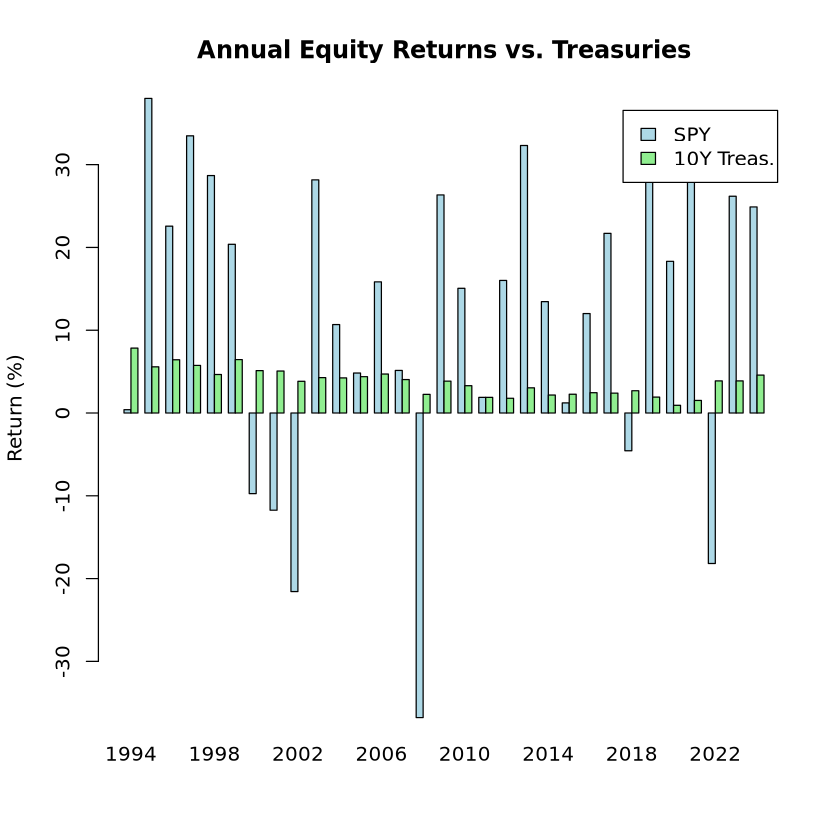

In [18]:
par(bg = "white")

barplot(height = t(as.matrix(erp_year[, .(annual_rtn, rate)])), beside = TRUE,
        names.arg = erp_year$year, col = c("lightblue", "lightgreen"),
        legend.text = c("SPY", "10Y Treas."),
        main = "Annual Equity Returns vs. Treasuries",
        xlab = NA, ylab = "Return (%)")

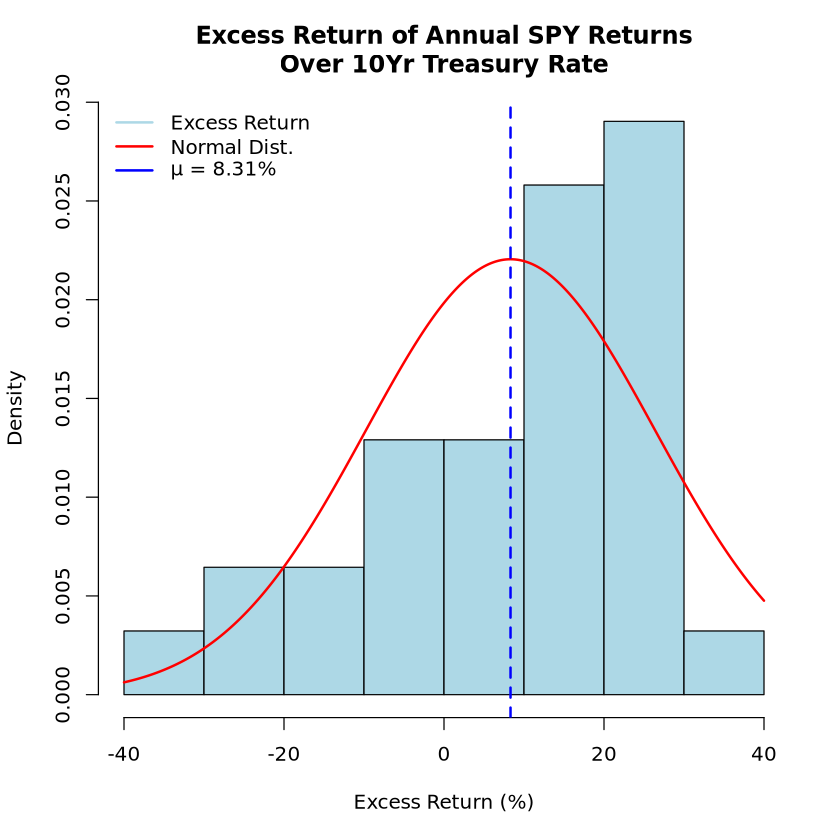

In [19]:
## Histogram of annual data
par(bg = "white")
hist(erp_year$erp, breaks = 10, col = "lightblue",
     xlab = "Excess Return (%)",
     main = "Excess Return of Annual SPY Returns\nOver 10Yr Treasury Rate",
     probability = TRUE)
lines(seq(-40, 40, 0.1), dnorm(seq(-40, 40, 0.1), mean = mean(erp_year$erp),
                               sd = sd(erp_year$erp)), col = "red", lwd = 2)
abline(v = mean(erp_year$erp), col = "blue", lwd = 2, lty = 2)
legend("topleft", legend = c("Excess Return", "Normal Dist.",
                             substitute(paste(mu, " = ", avg, "%", sep = ""),
                                        list(avg = round(mean(erp_year$erp),
                                                         digits = 2)))),
       col = c("lightblue", "red", "blue"), lwd = 2, bty = "n")

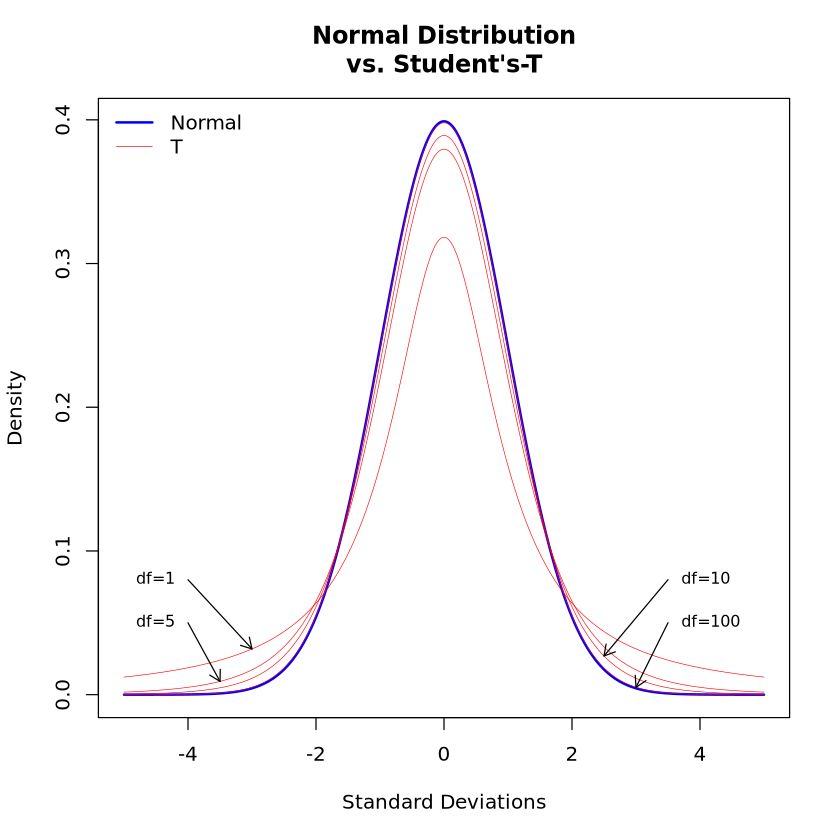

In [20]:
## Comparisson of Normal distribution vs. Student's T
par(bg = "white")
dfs = c(1, 5, 10, 100)
x <- seq(-5, 5, 0.01)
yn <- dnorm(x, mean = 0, sd = 1)
yt1 <- dt(x, 1)
yt2 <- dt(x, 5)
yt3 <- dt(x, 10)
yt4 <- dt(x, 100)
plot(x, yn, type = "l", col = "blue",
     main = "Normal Distribution\nvs. Student's-T",
     ylab = "Density", xlab = "Standard Deviations", lwd = 2)
lines(x, yt1, col = "red", lwd = 0.5)
lines(x, yt2, col = "red", lwd = 0.5)
lines(x, yt3, col = "red", lwd = 0.5)
lines(x, yt4, col = "red", lwd = 0.5)
legend("topleft", legend = c("Normal", "T"), col = c("blue", "red"),
       lwd = c(2, 0.5), lty = c(1, 1), bty = "n")
arrows(x0 = c(-4, -4, 3.5, 3.5), y0 = c(0.08, 0.05, 0.08, 0.05),
       x1 = c(-3.0, -3.5, 2.5, 3.0),
       y1 = c(yt1[x == -3.0], yt2[x == -3.5], yt3[x == 2.5], yt4[x == 3.0]),
       col = "black", lwd = 1, length = 0.1)
text(x = c(-5.0, -5.0, 3.52, 3.52), y = c(0.08, 0.05, 0.08, 0.05),
     labels = c("df=1", "df=5", "df=10", "df=100"), pos = 4, cex = 0.8)

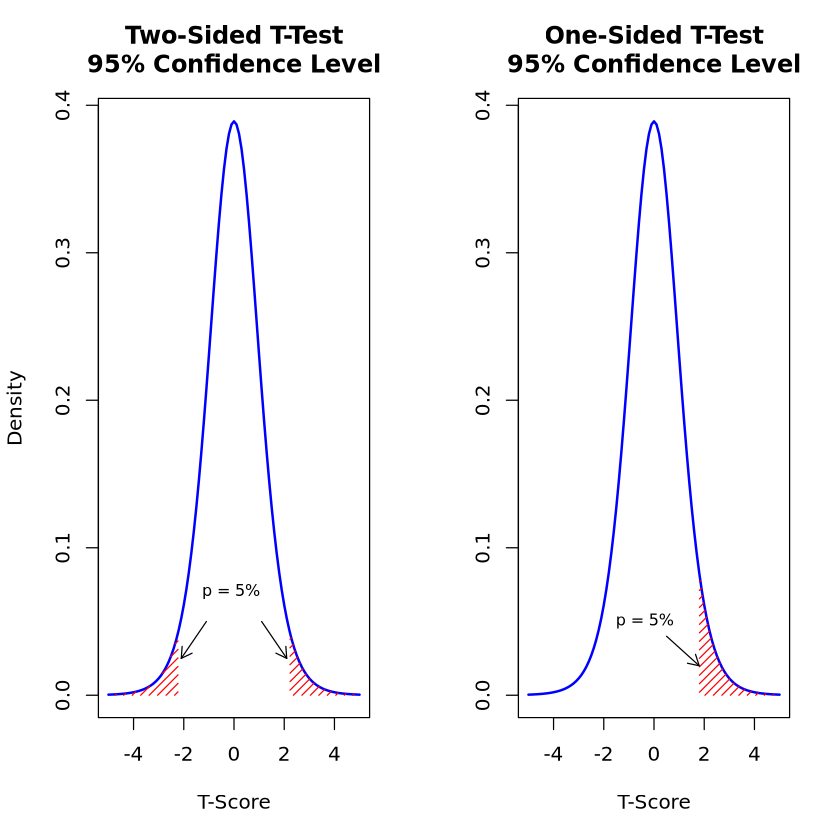

In [48]:
par(bg = "white", mfrow = c(1, 2))
df <- 10
cv <- -round(qt(p = 0.025, df = df), 2)
x <- seq(-5, 5, 0.1)
y <- dt(x, df = df)
plot(x, y, main = "Two-Sided T-Test\n95% Confidence Level",
     col = "blue", lwd = 2, type = "l", xlab = "T-Score", ylab = "Density")

critical_x <- c(-5, seq(-5, -cv, by = 0.01), -cv)
critical_y <- c(0, dt(seq(-5, -cv, by = 0.01), df = df), 0)
polygon(critical_x, critical_y, col = "red", border = NA, density = 20)
polygon(-rev(critical_x), rev(critical_y), col = "red",
        border = NA, density = 20)
arrows(x0 = c(-1.1, 1.1), y0 = c(0.05, 0.05), x1 = c(-2.1, 2.1),
       y1 = c(0.025, 0.025), col = "black", lwd = 1, length = 0.1)
text(-1.75, 0.07, labels = "p = 5%", pos = 4, cex = 0.8)

cv <- round(qt(p = 0.05, df = df, lower.tail = FALSE), 2)
plot(x, y, main = "One-Sided T-Test\n95% Confidence Level",
     col = "blue", lwd = 2, type = "l", xlab = "T-Score", ylab = NA)

critical_x <- c(cv, seq(cv, 5, by = 0.01), 5)
critical_y <- c(0, dt(seq(cv, 5, by = 0.01), df = df), 0)
polygon(critical_x, critical_y, col = "red", border = NA, density = 20)
arrows(x0 = 0.5, y0 = 0.04, x1 = 1.8, y1 = 0.02,
       col = "black", lwd = 1, length = 0.1)
text(x = -2, y = 0.05, labels = "p = 5%", pos = 4, cex = 0.8)

### Analysis of Variance (ANOVA)

Given our conclusion that, on average, ERP is positive, we might want to further determine if we get a different result 


In [49]:
year.data[-1, group := (year - min(year)) %/% 5 + 1]
grouped_data <- split(year.data, by = "group")[-1]

In [50]:
group_means <- unlist(lapply(grouped_data, function(x) mean(x$excess)))
group_means

1          2          3          4          5          6 
22.8526807 -5.3478938 -0.7711614 13.3066040  9.9721981 13.0313748

In [51]:
mu <- mean(year.data$excess)
ssb <- lapply(grouped_data, function(x){
  length(x$excess) * (mean(x$excess) - mu) * (mean(x$excess) - mu)
})
msb <- sum(unlist(ssb)) / (length(group_means) - 1)

In [52]:
ssb
msb

$`1`
[1] 1056.589

$`2`
[1] 933.4968

$`3`
[1] 412.8738

$`4`
[1] 124.5355

$`5`
[1] 13.71656

$`6`
[1] 111.1783

[1] 530.4781

In [53]:
ssw <- lapply(grouped_data, function(x){
  sum((x$excess - mean(x$excess))^2)
})
msw <- sum(unlist(ssw)) / (length(year.data$excess) - length(group_means))
ssw
msw

$`1`
[1] 241.4969

$`2`
[1] 1619.36

$`3`
[1] 2152.926

$`4`
[1] 439.1155

$`5`
[1] 879.0868

$`6`
[1] 1590.01

[1] 276.8798

In [54]:
f_score <- msb / msw
f_score
f_critical <- qf(0.95, df1 = length(group_means) - 1,
                 df2 = length(year.data$excess) - length(group_means))
f_critical

[1] 1.915914

[1] 2.602987